In [1]:
## system imports
import sys, os
import time
import copy

## loading imports
import json

## math imports
import numpy as np

## COCO imports
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask
from pycocotools.cocoanalyze import COCOanalyze

## plotting imports
%matplotlib inline
import matplotlib.patches as mpatches
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import skimage.io as io

In [2]:
'''
Set paths to data and load data
'''
## set paths of ground truth and detections
BASE_DIR = '/home/mronchi/Research/keypoint-2d-eval'
COCO_GT  = BASE_DIR + '/data/val_data.json'
DTS      = BASE_DIR + '/data/team_dts.json'
SAVE_DIR = BASE_DIR + '/outputs'

print "\n==============================================="
print "COCO_GT:      [%s]"%COCO_GT
print "DTS:          [%s]"%DTS
print "SAVE_DIR:     [%s]"%SAVE_DIR
print "===============================================\n"

## load coco ground-truth
coco_gt = COCO( COCO_GT )
print("{:15}[{}] instances in [{}] images.".format('Ground-truth:',
                                                   len(coco_gt.getAnnIds()),
                                                   len(coco_gt.getImgIds())))

## create imgs_info dictionary
with open(COCO_GT,'rb') as fp:
    data = json.load(fp)
imgs_info = {i['id']:{'id':i['id'] , 
                      'width':i['width'], 
                      'height':i['height']} 
                       for i in data['images']}
assert(len(coco_gt.getImgIds())==len(imgs_info))

## load team detections
with open(DTS,'rb') as fp: team_dts = json.load(fp)
team_dts     = [d for d in team_dts if d['image_id'] in imgs_info]
team_img_ids = set([d['image_id'] for d in team_dts])
print("{:15}[{}] instances in [{}] images.".format('Detections:',
                                                   len(team_dts),
                                                   len(team_img_ids)))

## create detection object
coco_dt   = coco_gt.loadRes(team_dts)

## create analyze object
coco_analyze = COCOanalyze(coco_gt,coco_dt,'keypoints')


COCO_GT:      [/home/mronchi/Research/keypoint-2d-eval/data/val_data.json]
DTS:          [/home/mronchi/Research/keypoint-2d-eval/data/team_dts.json]
SAVE_DIR:     [/home/mronchi/Research/keypoint-2d-eval/outputs]

loading annotations into memory...
Done (t=0.80s)
creating index...
index created!
Ground-truth:  [43862] instances in [20288] images.
Detections:    [47925] instances in [11940] images.
Loading and preparing results...
DONE (t=0.66s)
creating index...
index created!


In [3]:
# thresholds to use for analysis
coco_analyze.params.oksThrs       = [.95, .9, .85]

# smallest threshold considered a localization error
coco_analyze.params.oksLocThrs    = .1
# threshold limits for jitter errors
coco_analyze.params.jitterOksThrs = [.5,.85]

# area ranges for evaluation
# notice that 'all' range is union of medium and large

coco_analyze.params.areaRng       = [[32 ** 2, 1e5 ** 2]]
coco_analyze.params.areaRngLbl    = ['all']

# coco_analyze.params.areaRng       = [[32 ** 2, 96 ** 2]]
# coco_analyze.params.areaRngLbl    = ['medium']

# coco_analyze.params.areaRng       = [[96 ** 2, 1e5 ** 2]]
# coco_analyze.params.areaRngLbl    = ['large']

<mrr:2.0>Running per image evaluation...
<mrr:2.0>Evaluate annotation type *keypoints*
<mrr:2.0>DONE (t=8.15s).
<mrr:2.0>Accumulating evaluation results...
<mrr:2.0>DONE (t=0.06s).
<mrr:2.0>Verbose Summary:
 Average Precision  (AP) @[ IoU=0.85      | area=   all | maxDets= 20 ] = 0.488
 Average Precision  (AP) @[ IoU=0.90      | area=   all | maxDets= 20 ] = 0.327
 Average Precision  (AP) @[ IoU=0.95      | area=   all | maxDets= 20 ] = 0.096
 Average Precision  (AP) @[ IoU=0.85:0.95 | area=   all | maxDets= 20 ] = 0.303
 Average Precision  (AP) @[ IoU=0.85:0.95 | area=medium | maxDets= 20 ] = -1.000
 Average Precision  (AP) @[ IoU=0.85:0.95 | area= large | maxDets= 20 ] = -1.000
 Average Recall     (AR) @[ IoU=0.85      | area=   all | maxDets= 20 ] = 0.553
 Average Recall     (AR) @[ IoU=0.90      | area=   all | maxDets= 20 ] = 0.410
 Average Recall     (AR) @[ IoU=0.95      | area=   all | maxDets= 20 ] = 0.182
 Average Recall     (AR) @[ IoU=0.85:0.95 | area=   all | maxDets= 20 ]

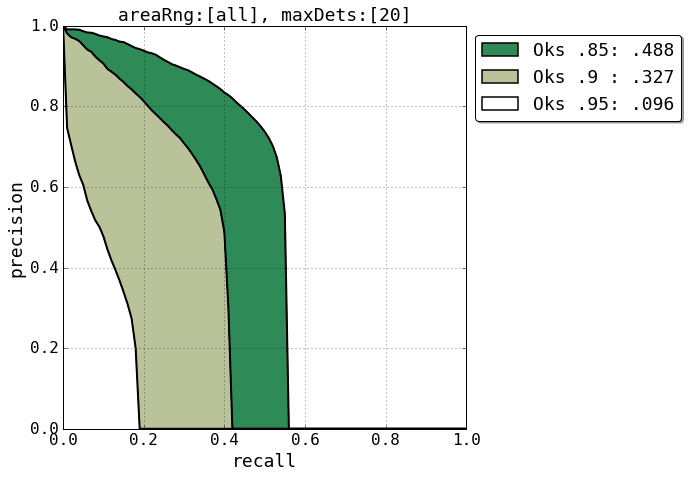

In [4]:
# use evaluate() method for standard coco evaluation 
# input arguments:
#  - verbose   : verbose outputs    (default: False)
#  - makeplots : plots eval results (default: False)
#  - savedir   : path to savedir    (default: None)
#  - team_name : team name string   (default: None)
coco_analyze.evaluate(verbose=True, makeplots=True)

In [5]:
# use analyze() method for advanced error analysis 
# input arguments:
#  - check_kpts   : analyze keypoint localization errors for detections with a match (default: True)
#                 : errors types are ['jitter','inversion','swap','miss']
#  - check_scores : analyze optimal score (maximizing oks over all matches) for every detection (default: True)
#  - check_false  : analyze background false positives and false negatives (default: True)
coco_analyze.analyze(check_kpts=True, check_scores=True, check_false=True)

<mrr:2.0>Analyzing detection errors: ['miss', 'swap', 'inversion', 'jitter']...
<mrr:2.0>Running per image evaluation...
<mrr:2.0>Evaluate annotation type *keypoints*
<mrr:2.0>DONE (t=7.92s).
Finding all errors causing false positives...
Done (t=8.71s).
<mrr:2.0>DONE (t=16.79s).
<mrr:2.0>Analyzing detection scores...
<mrr:2.0>Running per image *optimal score* evaluation...
<mrr:2.0>Evaluate annotation type *keypoints*
<mrr:2.0>DONE (t=9.28s).
<mrr:2.0>DONE (t=9.30s).


<mrr:2.0>Running per image evaluation...
<mrr:2.0>Evaluate annotation type *keypoints*
<mrr:2.0>DONE (t=8.73s).
<mrr:2.0>Accumulating evaluation results...
<mrr:2.0>DONE (t=0.07s).
<mrr:2.0>Verbose Summary:
 Average Precision  (AP) @[ IoU=0.85      | area=   all | maxDets= 20 ] = 0.488
 Average Precision  (AP) @[ IoU=0.90      | area=   all | maxDets= 20 ] = 0.327
 Average Precision  (AP) @[ IoU=0.95      | area=   all | maxDets= 20 ] = 0.096
 Average Precision  (AP) @[ IoU=0.85:0.95 | area=   all | maxDets= 20 ] = 0.303
 Average Precision  (AP) @[ IoU=0.85:0.95 | area=medium | maxDets= 20 ] = -1.000
 Average Precision  (AP) @[ IoU=0.85:0.95 | area= large | maxDets= 20 ] = -1.000
 Average Recall     (AR) @[ IoU=0.85      | area=   all | maxDets= 20 ] = 0.553
 Average Recall     (AR) @[ IoU=0.90      | area=   all | maxDets= 20 ] = 0.410
 Average Recall     (AR) @[ IoU=0.95      | area=   all | maxDets= 20 ] = 0.182
 Average Recall     (AR) @[ IoU=0.85:0.95 | area=   all | maxDets= 20 ]

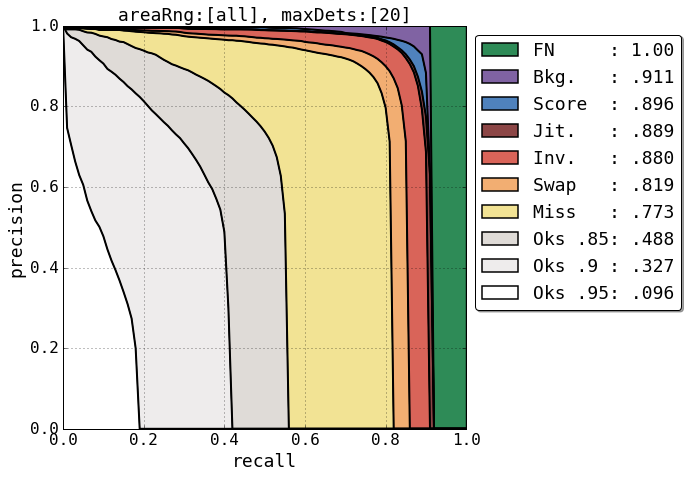

In [6]:
# use summarize() method to get the results after correcting for each one of the above results
# input arguments:
#  - makeplots : plots eval results (default: False)
#  - savedir   : path to savedir    (default: None)
#  - team_name : team name string   (default: None)
coco_analyze.summarize(makeplots=True)

In [7]:
# after running analyze() the results of the above ananysis are collected in the following variables:

# list of detections with optimal score and flags for keypoint errors
corrected_dts = coco_analyze.corrected_dts

# dictionary of detection and ground truth matches with info on the match (i.e. score, oks value)
dt_gt_matches = coco_analyze.matches

In [8]:
# after running summarize() the results of the above ananysis are collected in the following variables:
# list of ground truths that are false negatives
false_neg_gts = coco_analyze.false_neg_gts

# stats with performance before and after correcting errors
print coco_analyze.stats

[{'recall': 0.55341319330489003, 'oks': 0.85, 'auc': 0.48783927125121651, 'areaRng': 'all'}, {'recall': 0.41007548408270428, 'oks': 0.9, 'auc': 0.32657480149663559, 'areaRng': 'all'}, {'recall': 0.18169510994420743, 'oks': 0.95, 'auc': 0.095992348948320025, 'areaRng': 'all'}, {'recall': 0.8172382671480144, 'oks': 0.85, 'auc': 0.7732390832798709, 'err': 'miss', 'areaRng': 'all'}, {'recall': 0.8562520511978996, 'oks': 0.85, 'auc': 0.81949110846342876, 'err': 'swap', 'areaRng': 'all'}, {'recall': 0.90310141122415488, 'oks': 0.85, 'auc': 0.8799047673753263, 'err': 'inversion', 'areaRng': 'all'}, {'recall': 0.91060879553659335, 'oks': 0.85, 'auc': 0.88865869615617432, 'err': 'jitter', 'areaRng': 'all'}, {'recall': 0.91081391532655076, 'oks': 0.85, 'auc': 0.89618978323879472, 'err': 'score', 'areaRng': 'all'}, {'recall': 0.91081391532655076, 'oks': 0.85, 'auc': 0.91089108910891092, 'err': 'bkg_false_pos', 'areaRng': 'all'}, {'recall': 1.0, 'oks': 0.85, 'auc': 1.0, 'err': 'false_neg', 'areaRn